<a href="https://colab.research.google.com/github/EmilianoLS/DiTellaML/blob/main/Copy_of_Practica_1_UTDT_2021_Estudiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


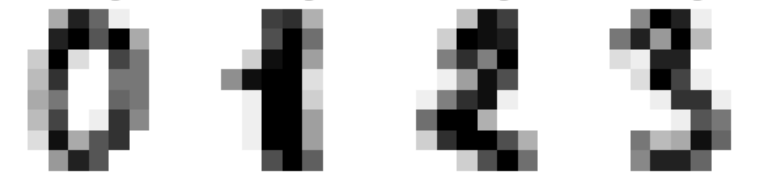



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

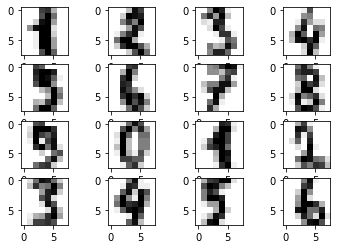

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [4]:
# Cargo los dígitos
#X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target

# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y==0) | (y == 1)]

X_bin = X[bin_indices,:,:]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print("Total de 0s para clasificación binaria: " + str(y_bin_test.shape[0] - y_bin_test.sum()))


Total de datos para clasificación entre 10 dígitos: 1797
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

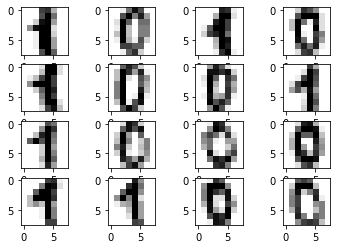

In [5]:
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(X_bin[i,:,:], cmap=plt.get_cmap('gray_r'))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

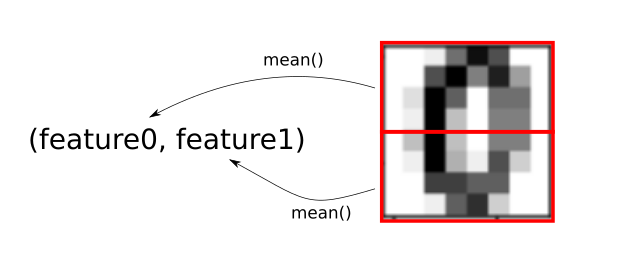

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

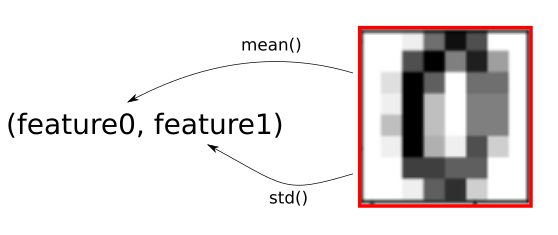


In [6]:
def extract_features_mean_std(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = np.mean(x)        # Calculo la media de la imagen 
  x_out[0,1] = np.std(x)           # Calculo el desvio estandar de la imagen

  return x_out

def extract_features_mean_top_bottom(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = np.mean(x[:4,:])  # Calculo la media de las primeras 4 filas 
  x_out[0,1] = np.mean(x[4:,:])  # Calculo la media de las ultimas 4 filas

  return x_out

def preprocess_features_mean_std(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))  # Crea una matriz de igual cantidad de registros como imagenes hay, y dos columnas para colocar ambos features

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_std(X[i,:,:]) # Va completando la matriz anterior con los datos de las funciones creadas

  return X_pp
  
def preprocess_features_mean_top_bottom(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_top_bottom(X[i,:,:])

  return X_pp

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

In [7]:
from sklearn.linear_model import Perceptron

# Definimos un pereceptrón para ambos modelos de features

clasificador = Perceptron()


# Transformamos las features de los datos para el problema binario
# Transfomracion para features Mean y STD
X_bin_train_features_mean = preprocess_features_mean_std(X_bin_train)
X_bin_test_features_mean = preprocess_features_mean_std(X_bin_test)

# Transformacion para las features Mean Top & Bottom
X_bin_train_features_top_bottom = preprocess_features_mean_top_bottom(X_bin_train)
X_bin_test_features_top_bottom = preprocess_features_mean_top_bottom(X_bin_test)

# Entrenamos el clasificador
# Features Mean & Std

clasificador.fit(X_bin_train_features_mean, y_bin_train)
score_mean = clasificador.score(X_bin_test_features_mean, y_bin_test)               # Get Score
mean_model_predictions = clasificador.predict(X_bin_test_features_mean)             # Get Predictions

# Features Mean & Bottom
clasificador.fit(X_bin_train_features_top_bottom, y_bin_train)
score_top_bottom = clasificador.score(X_bin_test_features_top_bottom, y_bin_test)   # Get Score
top_bottom_model_predictions = clasificador.predict(X_bin_test_features_top_bottom) # Get Predictions

# Print score
print("Test Accuracy - Mean & Std Model: " + str(score_mean))
print("Test Accuracy - Mean Top & Bottom model: " + str(score_top_bottom))
print(" ")

# Imprimir las predicciones realizadas para los datos de test
print("Predictions - Modelo Mean & Std: " + str(mean_model_predictions))
print("Predictions - Modelo Top & Bottom: " + str(top_bottom_model_predictions))

Test Accuracy - Mean & Std Model: 0.8319327731092437
Test Accuracy - Mean Top & Bottom model: 0.5378151260504201
 
Predictions - Modelo Mean & Std: [1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 1 1 0 0 1 0 0]
Predictions - Modelo Top & Bottom: [0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1
 0 1 1 1 0 1 1 1]


# Visualizando las features

Para entender el grado de discriminabilidad que presentan nuestras features, vamos a visualizarlas. Para hacerlo, colorear los items de cada clase con un color diferente.

Text(0, 0.5, 'Feature 1')

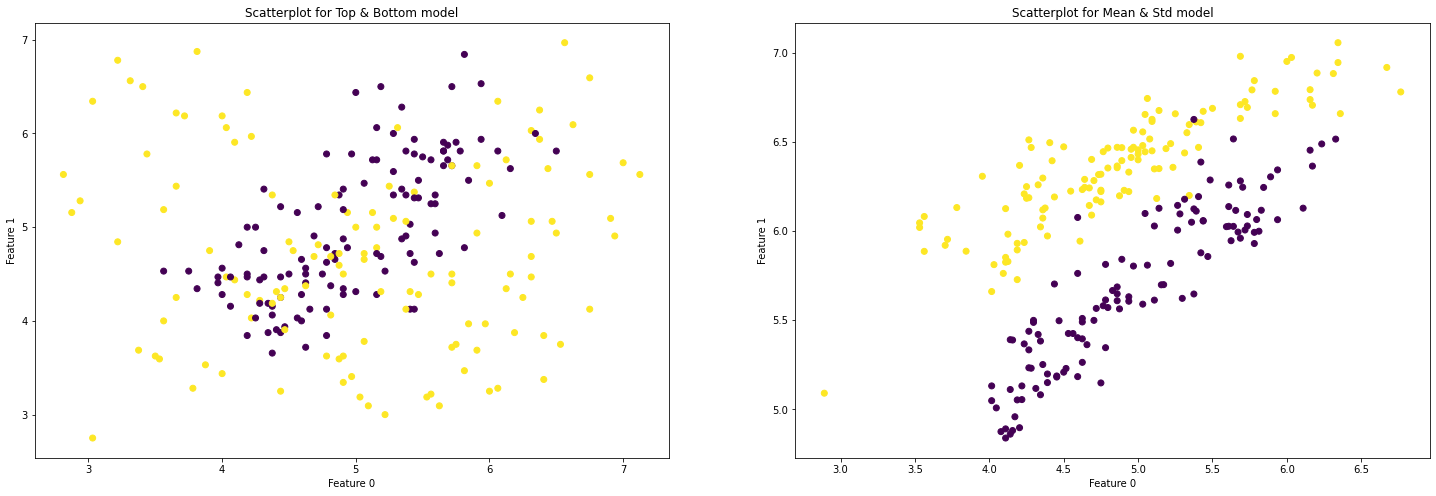

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,8))

# Modelo Mean Top & Bottom
ax[0].scatter( X_bin_train_features_top_bottom[:,0],X_bin_train_features_top_bottom[:,1], c = y_bin_train)
ax[0].set_title('Scatterplot for Top & Bottom model')
ax[0].set_xlabel('Feature 0')
ax[0].set_ylabel('Feature 1')

# Modelo Mean & Std
ax[1].scatter( X_bin_train_features_mean[:,0],X_bin_train_features_mean[:,1], c = y_bin_train)
ax[1].set_title('Scatterplot for Mean & Std model')
ax[1].set_xlabel('Feature 0')
ax[1].set_ylabel('Feature 1')

# Complicando las cosas: 


Ahora volvemos al caso de 10 dígitos y probamos la misma estrategia que estábamos usando anteriormente.

In [9]:
# Definimos un pereceptrón
clasificador10 = Perceptron()

# Preprocesamiento con la funcion de desvio y estandar

X_train_features_mean = preprocess_features_mean_std(X_train)
X_test_features_mean = preprocess_features_mean_std(X_test)

# Preprocesamiento con la funcion de mean top bottom

X_train_features_top_bottom = preprocess_features_mean_top_bottom(X_train)
X_test_features_top_bottom = preprocess_features_mean_top_bottom(X_test)

# Entreno el modelo para las features Mean & Std y obtengo las predicciones y el score

clasificador10.fit(X_train_features_mean, y_train)
score_mean_10 = clasificador10.score(X_test_features_mean, y_test)
mean_model_predictions_10 = clasificador10.predict(X_test_features_mean)

# Entreno el modelo para las features Top & Bottom y obtengo las predicciones y el score

clasificador10.fit(X_train_features_top_bottom, y_train)
score_top_bottom_10 = clasificador10.score(X_test_features_top_bottom, y_test)
top_bottom_model_predictions_10 = clasificador10.predict(X_test_features_top_bottom)

# Imprimir la accuracy en los datos de test.
print("Test Accuracy - Mean & Std Model: " + str(score_mean_10))
print("Test Accuracy - Top & Bottom Model: " + str(score_top_bottom_10))
print(" ")

# Imprimir las predicciones realizadas para los datos de test

print("Predictions - Mean & Std Model: " + str(mean_model_predictions_10))
print("Predictions - Top & Bottom Model: " + str(top_bottom_model_predictions_10))

Test Accuracy - Mean & Std Model: 0.13973063973063973
Test Accuracy - Top & Bottom Model: 0.16666666666666666
 
Predictions - Mean & Std Model: [5 8 5 5 5 5 5 5 5 5 5 5 8 8 5 5 8 8 8 8 5 5 8 5 5 5 5 5 5 8 5 8 5 5 5 8 5
 5 5 5 5 5 5 5 5 8 5 8 5 5 8 8 5 8 5 8 5 8 5 5 0 8 8 5 5 8 8 5 8 5 8 5 8 5
 5 5 5 5 5 8 8 5 5 5 8 8 5 5 5 8 5 5 8 5 8 5 5 8 5 8 5 8 5 5 5 5 5 5 5 8 5
 5 5 5 5 5 5 5 8 8 8 5 5 5 5 5 5 5 5 8 8 5 5 5 8 5 5 5 5 8 8 5 5 5 8 5 5 5
 8 5 5 5 8 8 5 8 8 5 5 5 5 5 8 8 5 5 8 5 5 5 8 8 8 5 5 5 5 5 5 5 8 8 8 8 5
 5 5 5 5 8 8 5 5 5 8 5 8 8 5 8 5 8 8 5 8 8 5 8 5 8 8 5 8 5 5 5 5 8 5 5 8 8
 5 8 5 5 5 8 5 5 5 8 5 5 5 5 5 5 5 5 5 8 5 5 8 5 8 8 5 8 5 5 5 8 8 5 5 5 5
 8 5 8 8 5 5 5 5 8 5 8 8 5 5 5 5 5 5 8 5 5 5 5 5 5 8 8 5 8 8 5 5 5 5 5 8 5
 8 5 5 5 8 5 5 5 5 5 8 8 8 8 5 5 5 8 5 8 5 5 5 5 5 8 5 8 5 8 5 5 8 8 5 5 8
 5 8 5 5 8 8 5 5 5 5 8 5 8 5 8 8 5 5 8 5 8 5 5 5 8 8 8 5 8 8 5 5 8 8 8 8 5
 5 8 5 5 5 5 5 5 8 8 5 5 5 8 8 8 5 8 5 8 5 8 8 5 5 5 5 8 5 8 8 5 5 5 5 5 8
 8 5 5 5 5 5 5 8 5 5 8 5 8 5 8 

Para intentar entender por qué disminuye tan drásticamente la performance, visualicen las features de las 10 clases coloreando cada punto en un color diferente como hicimos anteriormente.

Grafico las features del promedio y el desvio

Text(0, 0.5, 'Feature 1')

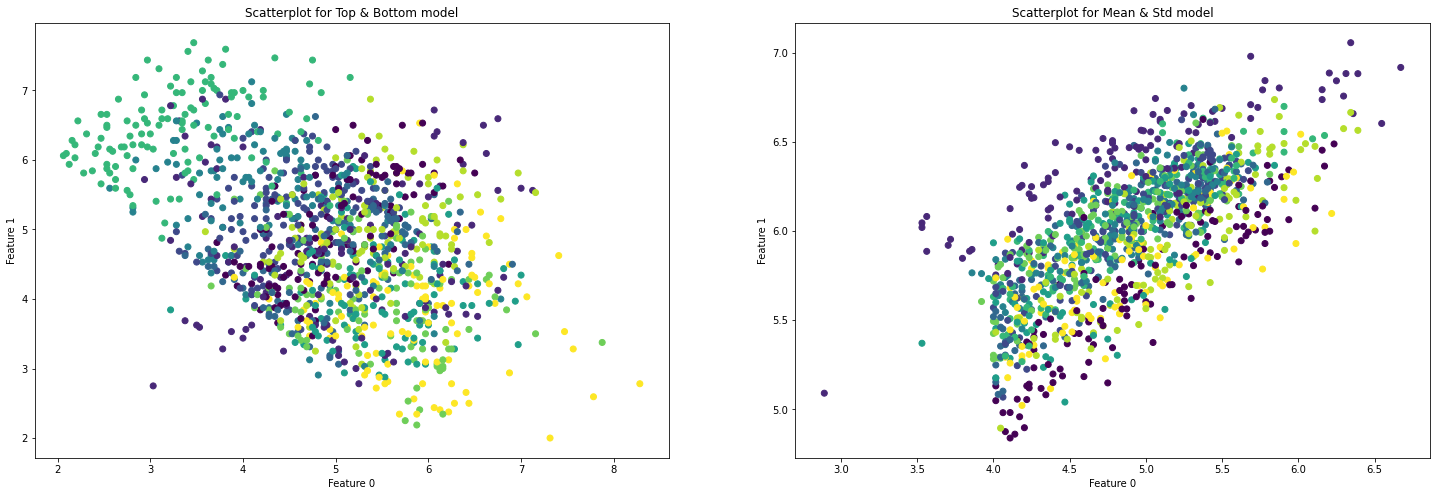

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,8))

# Modelo Mean Top & Bottom
ax[0].scatter( X_train_features_top_bottom[:,0],X_train_features_top_bottom[:,1], c = y_train)
ax[0].set_title('Scatterplot for Top & Bottom model')
ax[0].set_xlabel('Feature 0')
ax[0].set_ylabel('Feature 1')

# Modelo Mean & Std
ax[1].scatter( X_train_features_mean[:,0],X_train_features_mean[:,1], c = y_train)
ax[1].set_title('Scatterplot for Mean & Std model')
ax[1].set_xlabel('Feature 0')
ax[1].set_ylabel('Feature 1')

# Entregable:
* Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos? 

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



# Respuesta:



##¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

Segun los resultados obtenidos durante la experimentación, se puede llegar a dos respuestas según el escenario donde nos encontremos:

* Escenario A: Modelo Binarizado (contempla unicamente dígitos 1 y 0)
* Escenario B: Modelo completo (contempla todos los dígitos de 0 a 9)

Para el escenario A, se observa que el modelo que mejor resultados arrojó fue aquel que extrajo las características mediante la estrategia de *Mean & Std*. Es decir, aquel modelo cuyas *features* eran la media del valor de los píxeles y el desvío estandar de los mismos.

A continuación se muestra el *Accuracy* obtenido para ambos modelos:

In [11]:
print("Test Accuracy - Mean & Std Model: " + str(score_mean))
print("Test Accuracy - Mean Top & Bottom model: " + str(score_top_bottom))

Test Accuracy - Mean & Std Model: 0.8319327731092437
Test Accuracy - Mean Top & Bottom model: 0.5378151260504201


Para entender mejor, se plotean ambas *features*, para ambos modelos:

Text(0, 0.5, 'Feature 1')

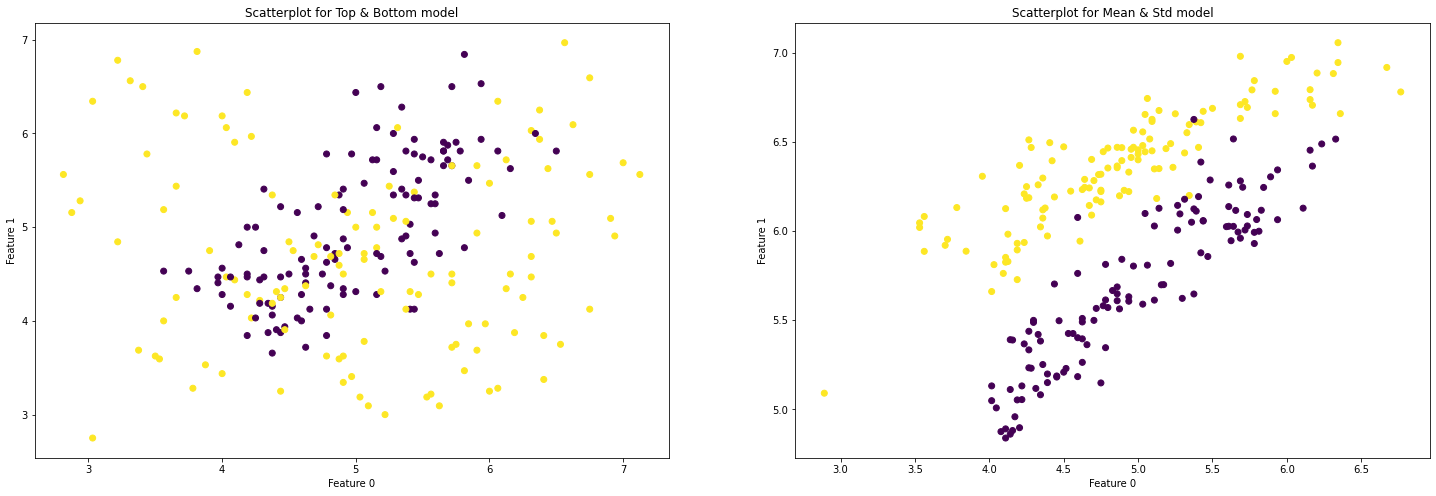

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,8))

# Modelo Mean Top & Bottom
ax[0].scatter( X_bin_train_features_top_bottom[:,0],X_bin_train_features_top_bottom[:,1], c = y_bin_train)
ax[0].set_title('Scatterplot for Top & Bottom model')
ax[0].set_xlabel('Feature 0')
ax[0].set_ylabel('Feature 1')

# Modelo Mean & Std
ax[1].scatter( X_bin_train_features_mean[:,0],X_bin_train_features_mean[:,1], c = y_bin_train)
ax[1].set_title('Scatterplot for Mean & Std model')
ax[1].set_xlabel('Feature 0')
ax[1].set_ylabel('Feature 1')

Estas visualizaciones permiten comprender por qué un modelo funcionó mejor que el otro. 

Ya que las *features* son los elementos que le permiten "aprender" al *Perceptron*, los mismos deben contener información valiosa que ayuden a la red a clasificar adecuadamente. En otras palabras, las características que describen la imagen tienen que ser relevantes y lo suficientemente descriptivas para que el modelo pueda clasificar adecuadamente.

En el primer gráfico (a la izquierda) observamos las *features* compuestas por la media de la partes superior e inferior de la imagen. Adicionalmente, se colorean las dos clases para poder visualizar el grado de separación obtenido con las *features*.
Se puede observar que ambas clases (es decir, las imágenes de ceros y unos) se encuentran muy superpuestas. Esto se traduce en que el modelo tendrá dificultades para poder diferenciar un número de otro. 

Esto se demuestra en el bajo *accuracy* obtenido para este modelo, ya que no hay forma de separar correctamente ambas clases.

Esto cambia para el segundo modelo (gráfico de la derecha) ya que ambas clases se encuentran casi completamente separadas, con excepción de algunos casos puntuales. En conclusión, las *features* de la media y el desvío de los valores de los píxeles de las imágenes resultan ser muy buenas características descriptivas de las mismas, ya que permiten diferenciar muy bien ambos tipos de imágenes.
Para explicar por qué esto es así, podemos visualizar las siguientes imágenes:

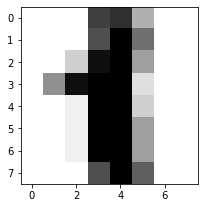

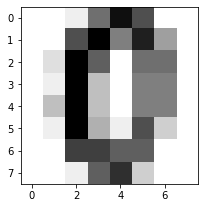

In [13]:
for i in range(1,3):
    plt.figure(figsize = (15,15))
    plt.subplot(4,4,i)
    plt.imshow(X_bin[i,:,:], cmap=plt.get_cmap('gray_r'))

Vemos que para el caso de un cero, los valores de los píxeles se encuentran más distribuidos o balanceados entre píxeles oscuros y claros. Sin embargo, si la imagen es un uno, los píxeles con valores más altos (píxeles en blanco) serán mucho más comunes, por lo que la media será mucho mayor que la de una imagen con un cero. 

Por este motivo, las *features* seleccionadas son adecuadas para este tipo de problema binarizado.

Sin embargo, estos resultados corresponden al primer escenario binarizado. 

La conclusión cambia para el caso donde se intenta clasificar todas las imágenes. En este caso, ninguno de los dos modelos da buenos resultados (a pesar de que se observa una leve superioridad entre los modelos), como se ve a continuación:

In [14]:
print("Test Accuracy - Mean & Std Model: " + str(score_mean_10))
print("Test Accuracy - Top & Bottom Model: " + str(score_top_bottom_10))

Test Accuracy - Mean & Std Model: 0.13973063973063973
Test Accuracy - Top & Bottom Model: 0.16666666666666666


Puede observarse que en este caso, ningún modelo performó adecuadamente o de forma satisfactoria. 

Si ambas features se plotean nuevamente, para cada modelo, podremos entender por qué es así:

Text(0, 0.5, 'Feature 1')

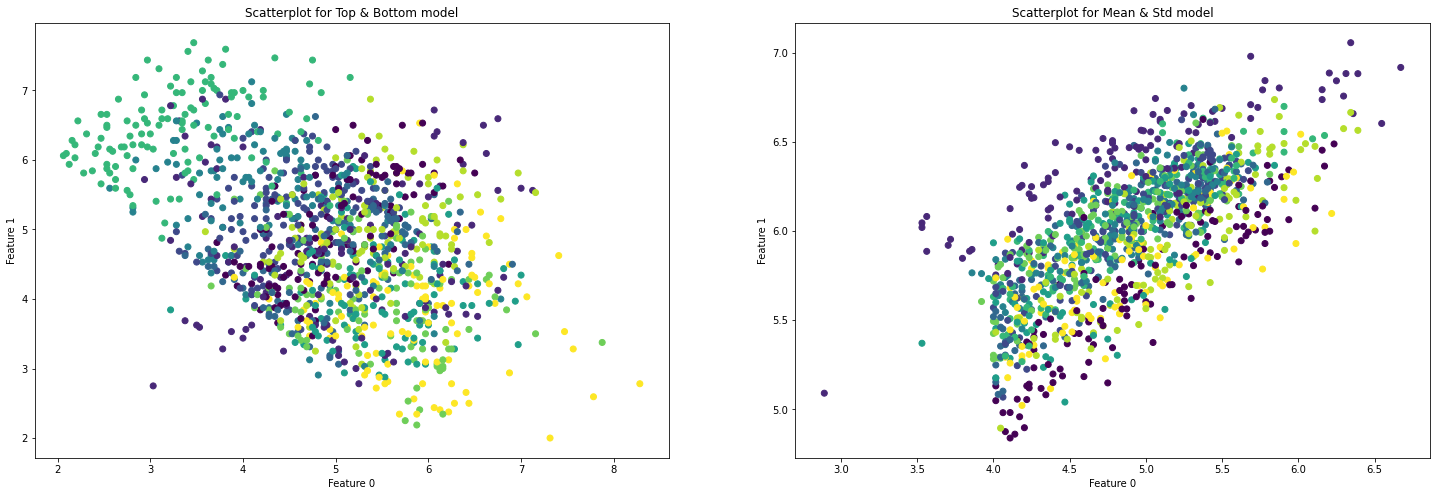

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,8))

# Modelo Mean Top & Bottom
ax[0].scatter( X_train_features_top_bottom[:,0],X_train_features_top_bottom[:,1], c = y_train)
ax[0].set_title('Scatterplot for Top & Bottom model')
ax[0].set_xlabel('Feature 0')
ax[0].set_ylabel('Feature 1')

# Modelo Mean & Std
ax[1].scatter( X_train_features_mean[:,0],X_train_features_mean[:,1], c = y_train)
ax[1].set_title('Scatterplot for Mean & Std model')
ax[1].set_xlabel('Feature 0')
ax[1].set_ylabel('Feature 1')

Evidentemente, las *features* seleccionadas no son adecuadas para diferenciar correctamente entre los distintos dígitos.

Esto es así porque la diferencia ya no es tan clara como entre un cero y un uno. Cuando se observan las *features* obtenidas, los valores pasan a ser muy similares entre los distintos números, dificultando el trabajo de clasificación.

## ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos?

Si contamos con un modelo que asigne aleatoriamente las clases, entonces la probabilidad de asignar una imagen a una clase particular será de:

${P} = \frac{1}{Classes}$

Por lo cual, es de esperar que el *accuracy* en el caso del modelo binario sea del 50% y para el caso del modelo completo de un 10%. 

Para demostrarlo, creo una función que selleciona un número entero entre 0 y N, pudiendo valer esta última 1 o 9 según el escenario donde nos encontremos.
Esto lo hace M veces, simulando un algoritmo de clasificación, y luego contrastamos los datos reales contra lo predicho para demostrar los valores de *accuracy* estimados anteriormente.

In [16]:
import random # Importo la librería que permite obtener numeros aleatorios

In [17]:
def generate_random_list(N, M):
  # Esta funcion genera una lista de M numeros aleatorios que van desde
  # 0 hasta N

  random_list = [random.randint(0,N) for x in range(0,M)]
  return random_list

In [24]:
# Modelo binario
y_pred_bin = generate_random_list(1, 100000)
accuracy_bin = [True if x == y else False for x,y in zip(y_bin_test, y_pred_bin)]

# Modelo completo
y_pred = generate_random_list(9, 100000)
accuracy = [True if x == y else False for x,y in zip(y_test, y_pred)]


print('Random Binary Model Accuracy: ', sum(accuracy_bin)/len(accuracy_bin))
print('Random Model Accuracy: ', sum(accuracy)/len(accuracy))

Random Binary Model Accuracy:  0.48739495798319327
Random Model Accuracy:  0.1111111111111111


Con este sencillo ejemplo, queda demostrado que si tuviesemos un modelo predictivo que asignara clases de manera aleatoria, los resultados serían los estimados anteriormente. Es decir, se estima un *accuracy* igual a la probabilidad de asignar una clase de las N posibles.

## El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?

En base a los resultados que se obvutiveron en el punto 2, se puede concluir:

* En el caso del modelo binario, el *Perceptron* performo mucho mejor que un modelo aleatorio. Esto se debe a la calidad de los *features* generados, pero sobretodo porque solamente se trabajo con dos clases, lo que permitió que los atributos que describían esas imágenes aportara más información al modelo que el puro azar.
* En el caso del modelo multiclase, el *Perceptron* performo ligeramente mejor que un modelo aleatorio, pero para fines prácticos, la diferencia no es significativa. Por lo que se puede concluir que el modelo no es útil ya que no se obtiene mejores resultados que el azar (que corresponde a nuestro peor escenario posible).

**Nota**: Si uno quisiera observar más en detalle la performance del modelo multiclase y el modelo multiclase aleatorio, el modelo multiclase con las features *Top & Bottom* logró superar al modelo aleatorio en un 6%. Sin embargo, si bien es superior, no es lo suficiente como para considerar a este modelo un **"buen clasificador"** 

In [28]:
import pandas as pd

# Creo un dataframe con todos los scores para poder visualizarlos juntos 

# Guardo los scores del modelo aleatorio en variables
score_bin_random = sum(accuracy_bin)/len(accuracy_bin)
score_random_10 = sum(accuracy)/len(accuracy)

# Creo el dataframe
score_df = pd.DataFrame({
    
    'modelo': ['Binario', 'Multiclase'],
    'mean_score': [score_mean, score_mean_10],
    'top_bottom_score':[score_top_bottom, score_top_bottom_10],
    'random_score':[score_bin_random, score_random_10]
})

# Dataframe final
score_df

,modelo,mean_score,top_bottom_score,random_score
0,Binario,0.831933,0.537815,0.487395
1,Multiclase,0.139731,0.166667,0.111111


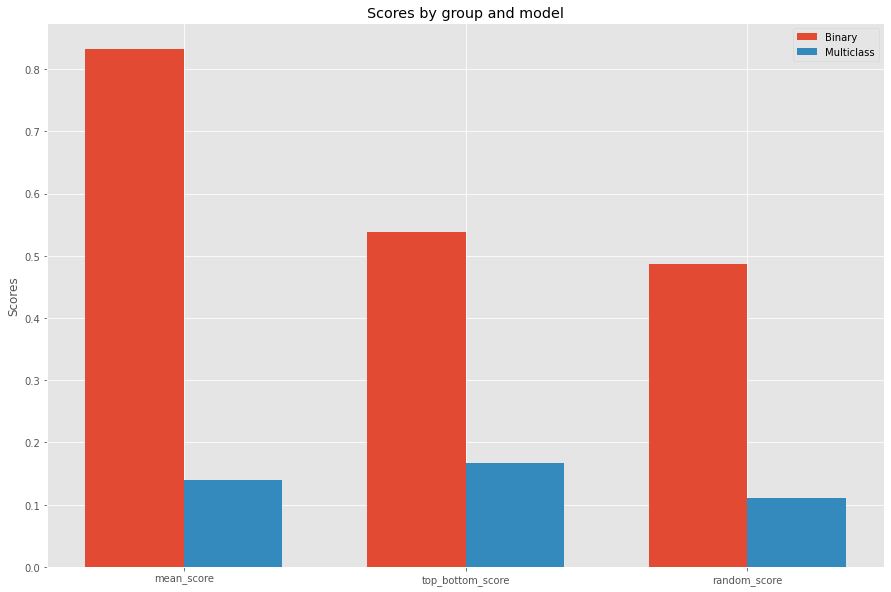

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')


labels = score_df.iloc[0, 1:].index.tolist()

bin_scores = score_df.iloc[0, 1:].values.tolist()
multi_scores = score_df.iloc[1, 1:].values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,10))
rects1 = ax.bar(x - width/2, bin_scores, width, label = 'Binary')
rects2 = ax.bar(x + width/2, multi_scores, width, label='Multiclass')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

Visualmente se puede observar que el modelo con mejor *performance* fue el modelo binario entrenado con el *perceptron*, utilizando las features de *Mean & Std*. Cualquier otro modelo performa igual que el mismo azar.

Evidentemente el modelo multiclase es el que necesita más trabajo de variables ya que los resultados obtenidos en *accuracy* son muy bajos.

A pesar de que el modelo aleatorio no funciona mejor que los otros, se observa que para el caso de la multiclase, los modelos anteriores performan casi tan mal como este.